/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml/scene0695_00


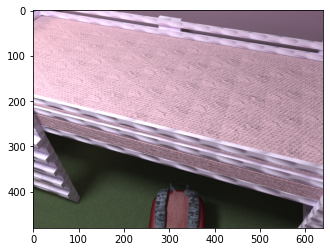

In [3]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

dataset_root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
png_root_path = Path('/data/ruizhu/OR-pngs/')
# scene_name = 'scene0004_00'
valid_scenes_path = Path('/home/ruizhu/Documents/Projects/Total3DUnderstanding/valid_scenes.pkl')
with open(valid_scenes_path, 'rb') as f:
     a = pickle.load(f)
# [meta_split, scene_name] = a[random.randint(0, len(a))].split('/')
meta_split, scene_name = 'main_xml/scene0695_00'.split('/')
frame_id = 1

scene_path = dataset_root_path / meta_split / scene_name
scene_pngs_path = png_root_path / meta_split / scene_name
print(scene_path)

im_path = scene_pngs_path / ('im_%d.png'%frame_id)

im_rgb = plt.imread(str(im_path))

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.imshow(im_rgb)
plt.show()

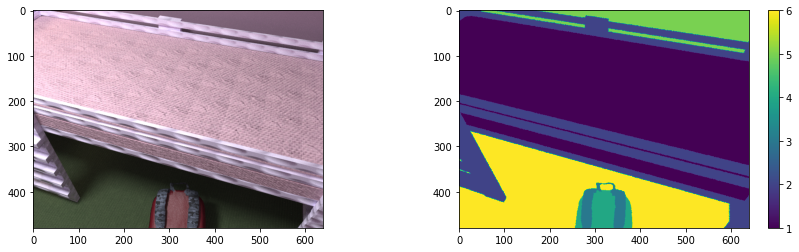

/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/scenes/xml/scene0695_00/main.xml
0.0006880760192871094


In [17]:
hdr_image_path = str(scene_path / ('im_%d.hdr'%frame_id))
seg_path = hdr_image_path.replace('im_', 'immask_').replace('hdr', 'png').replace('DiffMat', '')
# Read segmentation
seg = 0.5 * (loadImage(seg_path ) + 1)[0:1, :, :]
semantics_path = hdr_image_path.replace('DiffMat', '').replace('DiffMat', '').replace('DiffLight', '')
# mask_path = semantics_path.replace('im_', 'imcadmatobj_').replace('hdr', 'dat')
mask_path = semantics_path.replace('im_', 'immatPart_').replace('hdr', 'dat')
mask = loadBinary(mask_path, channels = 3, dtype=np.int32, if_resize=True).squeeze() # [h, w, 3]


mat_aggre_map, num_mat_masks, mat_list = get_map_aggre_map(mask) # 0 for invalid region
# im_matseg_transformed_trainval, mat_aggre_map_transformed = self.transforms_matseg(im_RGB_uint8, mat_aggre_map.squeeze()) # augmented
# mat_aggre_map = mat_aggre_map_transformed.numpy()[..., np.newaxis]
mat_aggre_map = mat_aggre_map[..., np.newaxis]

h, w, _ = mat_aggre_map.shape
gt_segmentation = mat_aggre_map
segmentation = np.zeros([50, h, w], dtype=np.uint8)
for i in range(num_mat_masks+1):
    if i == 0:
        # deal with backgroud
        seg = gt_segmentation == 0
        segmentation[num_mat_masks, :, :] = seg.reshape(h, w) # segmentation[num_mat_masks] for invalid mask
    else:
        seg = gt_segmentation == i
        segmentation[i-1, :, :] = seg.reshape(h, w) # segmentation[0..num_mat_masks-1] for plane instances
return_dict = {
    'mat_aggre_map': torch.from_numpy(mat_aggre_map),  # 0 for invalid region
    # 'mat_aggre_map_reindex': torch.from_numpy(mat_aggre_map_reindex), # gt_seg
    'num_mat_masks': num_mat_masks,  
    'mat_notlight_mask': torch.from_numpy(mat_aggre_map!=0).float(),
    'instance': torch.ByteTensor(segmentation), # torch.Size([50, 240, 320])
    'semantic': 1 - torch.FloatTensor(segmentation[num_mat_masks, :, :]).unsqueeze(0), # torch.Size([50, 240, 320]) torch.Size([1, 240, 320])
#     'im_matseg_transformed_trainval': im_matseg_transformed_trainval
}

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.imshow(im_rgb)
plt.subplot(122)
plt.imshow(mat_aggre_map)
plt.colorbar()
plt.show()


xml_root = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/scenes/')
xml_path = xml_root / meta_split.split('_')[1] / scene_name / (meta_split.split('_')[0] + '.xml')
print(xml_path)
models_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/models.txt')
with open(models_path, 'r') as fIn:
    lines = [x.strip() for x in fIn.readlines()]
modelStrIdDict = {'_'.join(x.split(' ')[:2]): int(x.split(' ')[2]) for x in lines[1:]}

tic = time.time()
dest_file = scene_bsdf_dicts_folder / meta_split / ('%s.pkl'%scene_name)
with open(dest_file, 'rb') as f:
    a = pickle.load(f)
print(time.time() - tic)
bsdfIdDict, bsdfIdDictInverse = a['bsdfIdDict'], a['bsdfIdDictInverse']

# ==== generate and write and read
# import time
# tic = time.time()
# bsdfIdDict, bsdfIdDictInverse = getBsdfIdDict(xml_path, modelStrIdDict)
# print(time.time() - tic)

# dest_file = '/home/ruizhu/Downloads/a.pkl'
# with open(dest_file, 'wb') as f:
#     pickle.dump({'bsdfIdDict': bsdfIdDict, 'bsdfIdDictInverse': bsdfIdDictInverse}, f, protocol=pickle.HIGHEST_PROTOCOL)

# tic = time.time()
# with open(dest_file, 'rb') as f:
#     a = pickle.load(f)
# print(time.time() - tic)
# bsdfIdDict, bsdfIdDictInverse = a['bsdfIdDict'], a['bsdfIdDictInverse']

02818832_3acfa3c60a03415643abcff1f32a8b0c


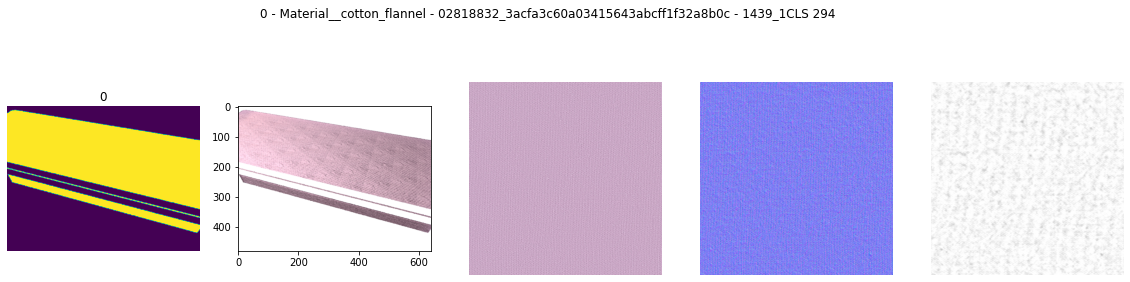

02818832_3acfa3c60a03415643abcff1f32a8b0c


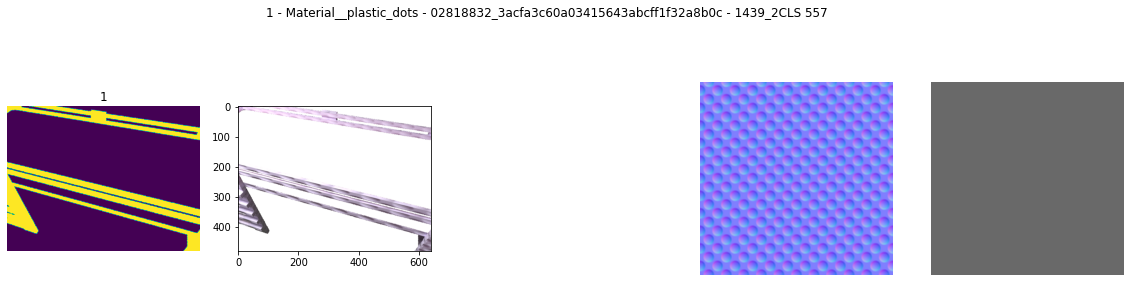

02773838_54cd45b275f551b276bb31db0358e9c6


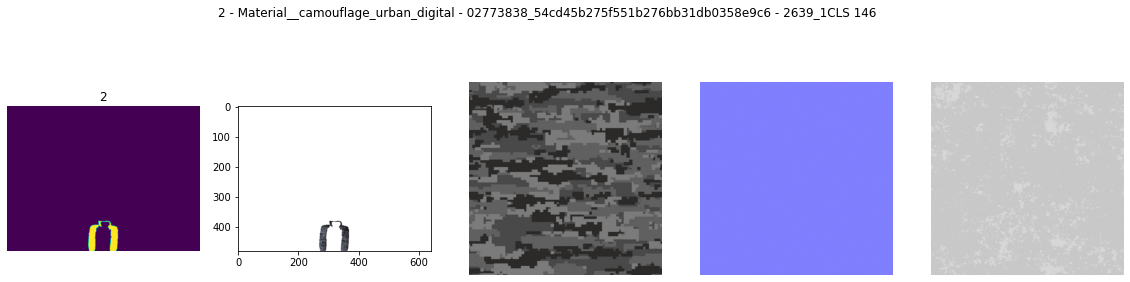

02773838_54cd45b275f551b276bb31db0358e9c6


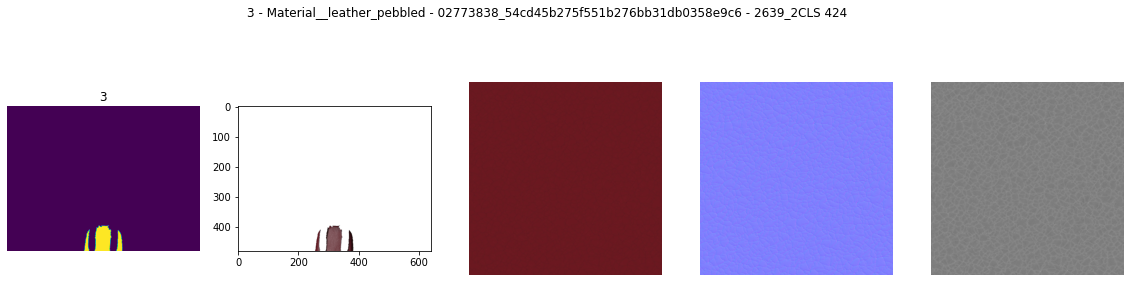

scene0695_00


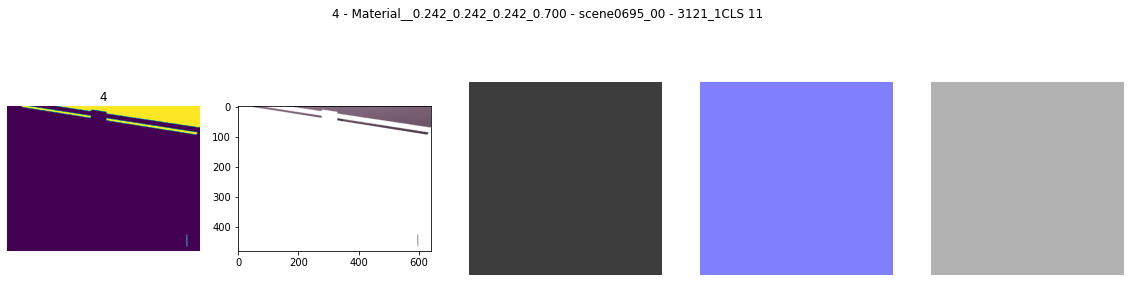

scene0695_00


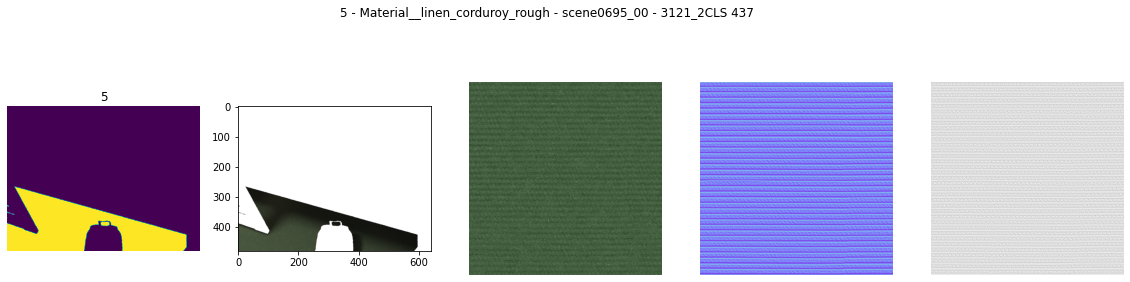

In [50]:
material_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/BRDFOriginDataset')
material_path_yy = Path('/home/ruizhu/Documents/data/BRDFScaledDataset')


for i in range(num_mat_masks):
    fig = plt.figure(figsize=(20, 5))
    plt.subplot(151)
    plt.imshow(segmentation[i])
    plt.axis('off')
    plt.title(str(i))
    plt.subplot(152)
    im_rgb_c = np.copy(im_rgb)
#     print((segmentation[i]==0).shape)
    im_rgb_c[segmentation[i]==0] = 1.

    plt.imshow(im_rgb_c)
    
    cad_mat_key = str(mat_list[i]['cadId'])+'_'+str(mat_list[i]['matId'])
#     if cad_mat_key not in bsdfIdDictInverse:
#         fig.suptitle(' - '.join([str(i), 'N/A', cad_mat_key]))
#         continue
    part_model, mat_name, mat_ifpre, objName = bsdfIdDictInverse[cad_mat_key]
#     mat_show = str(mat_path).split('/')[-1] if mat_path is not None else 'N/A'
    mat_cls_yy = mat_cls_list_yy[mat_name] if mat_name in mat_cls_list_yy.keys() else -1
    fig.suptitle(' - '.join([str(i), mat_name, objName, cad_mat_key]) + 'CLS %d'%mat_cls_yy)
    print(objName)

#     if mat_path is None:
#         continue
    if mat_ifpre:
        mat_path = material_path / mat_name

        plt.subplot(153)
        plt.imshow(plt.imread(str(mat_path / 'tiled' / 'diffuse_tiled.png')))
        plt.axis('off')
        plt.subplot(154)
        plt.imshow(plt.imread(str(mat_path / 'tiled' / 'normal_tiled.png')))
        plt.axis('off')
        plt.subplot(155)
        plt.imshow(plt.imread(str(mat_path / 'tiled' / 'rough_tiled.png')))
        plt.axis('off')
    else:
        rgb, rough = mat_name.split('_')[2:5], mat_name.split('_')[5]
        albedo, normal, rough = albedo_roughness_to_imgs(rgb, rough)
        plt.subplot(153)
        plt.imshow(np.array(albedo))
        plt.axis('off')
        plt.subplot(154)
        plt.imshow(np.array(normal))
        plt.axis('off')
        plt.subplot(155)
        plt.imshow(np.stack((np.array(rough),)*3, axis=-1))
        plt.axis('off')


        pass
    
    plt.show()


In [43]:
def albedo_roughness_to_imgs(rgb, rough):
    r, g, b = rgb
    rs, gs, bs = 1., 1., 1.
    roughs = 1.
    rescaled = lambda v, vs: int(float(v) * float(vs) * 255)
    albedo = Image.new('RGB', (512, 512), (rescaled(r, rs), rescaled(g, gs), rescaled(b, bs)))
    normal = Image.new('RGB', (512, 512), (128, 128, 255))
#     normal = normal.save(normalFileOut)
    rough = Image.new('L', (512, 512), rescaled(rough, roughs))
    return albedo, normal, rough

# batch gen

In [14]:
from tqdm import tqdm
from multiprocessing import Pool

scene_bsdf_dicts_folder = Path('/data/ruizhu/OR-scene_bsdf_dicts_includeHomoMat')
scene_bsdf_dicts_folder.mkdir(exist_ok=True)

def process_scene(line):
    meta_split, scene_name = line.split('/')
    scene_path = dataset_root_path / meta_split / scene_name
    scene_pngs_path = png_root_path / meta_split / scene_name

    xml_path = xml_root / meta_split.split('_')[1] / scene_name / (meta_split.split('_')[0] + '.xml')
    with open(models_path, 'r') as fIn:
        lines = [x.strip() for x in fIn.readlines()]
    modelStrIdDict = {'_'.join(x.split(' ')[:2]): int(x.split(' ')[2]) for x in lines[1:]}

    bsdfIdDict, bsdfIdDictInverse = getBsdfIdDict(xml_path, modelStrIdDict, include_homoMat=True)
    
    (scene_bsdf_dicts_folder / meta_split).mkdir(exist_ok=True)
    dest_file = scene_bsdf_dicts_folder / meta_split / ('%s.pkl'%scene_name)
    with open(dest_file, 'wb') as f:
        pickle.dump({'bsdfIdDict': bsdfIdDict, 'bsdfIdDictInverse': bsdfIdDictInverse}, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    return [bsdfIdDictInverse[x][1] for x in bsdfIdDictInverse]

valid_scenes_path = Path('/home/ruizhu/Documents/Projects/Total3DUnderstanding/valid_scenes.pkl')
with open(valid_scenes_path, 'rb') as f:
    valid_scenes_list = pickle.load(f)

tic = time.time()
from multiprocessing import Pool
p = Pool(processes=16)
all_mat_used_list = list(tqdm(p.imap_unordered(process_scene, valid_scenes_list), total=len(valid_scenes_list)))
# all_mat_used_list = p.map(process_scene, valid_scenes_list)

p.close()
p.join()

print(time.time() - tic, 'seconds passed.')

all_mat_used = [item for sublist in all_mat_used_list for item in sublist]
print(len(set([x for x in all_mat_used if x is not None])))


100%|██████████| 7049/7049 [02:38<00:00, 44.39it/s]

162.35629391670227 seconds passed.


NameError: name 'all_mat_used' is not defined

890


# Yu-Ying's materials

In [24]:
mat_root_path = Path('/home/ruizhu/Documents/data/BRDFScaledDataset')
mat_list_yy = [x for x in mat_root_path.iterdir() if 'Material' in str(x)]

mat_cls_list_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/matIdGlobal1.txt')
with open(mat_cls_list_path, 'r') as fIn:
    lines = [x.strip() for x in fIn.readlines()]
assert int(lines[0]) == len(lines[2:])
mat_cls_list_yy = {x.split(' ')[0]: int(x.split(' ')[1]) for x in lines[2:]}

In [25]:
mat_cls_list_yy

{'Material__0.020_0.020_0.020_0.100': 1,
 'Material__0.020_0.020_0.020_0.700': 2,
 'Material__0.100_0.100_0.100_0.100': 3,
 'Material__0.100_0.100_0.100_0.200': 4,
 'Material__0.100_0.100_0.100_0.700': 5,
 'Material__0.168_0.168_0.168_0.100': 6,
 'Material__0.168_0.168_0.168_0.700': 7,
 'Material__0.235_0.235_0.235_0.000': 8,
 'Material__0.242_0.242_0.242_0.100': 9,
 'Material__0.242_0.242_0.242_0.200': 10,
 'Material__0.242_0.242_0.242_0.700': 11,
 'Material__0.429_0.429_0.429_0.000': 12,
 'Material__0.500_0.500_0.500_0.100': 13,
 'Material__0.500_0.500_0.500_0.700': 14,
 'Material__0.565_0.565_0.565_0.000': 15,
 'Material__0.604_0.604_0.604_0.100': 16,
 'Material__0.604_0.604_0.604_0.700': 17,
 'Material__0.617_0.617_0.617_0.022': 18,
 'Material__0.800_0.800_0.800_0.100': 19,
 'Material__0.800_0.800_0.800_0.700': 20,
 'Material__0.847_0.847_0.847_0.100': 21,
 'Material__0.847_0.847_0.847_0.700': 22,
 'Material__0.863_0.863_0.863_0.100': 23,
 'Material__0.863_0.863_0.863_0.700': 24,
 

# support funcs

In [11]:
import os.path as osp
from PIL import Image
import struct

def loadImage(imName, isGama = False):
    if not(osp.isfile(imName ) ):
        self.logger.warning('File does not exist: ' + imName )
        assert(False )

    im = Image.open(imName)

    im = np.asarray(im, dtype=np.float32)
    if isGama:
        im = (im / 255.0) ** 2.2
        im = 2 * im - 1
    else:
        im = (im - 127.5) / 127.5
    if len(im.shape) == 2:
        im = im[:, np.newaxis]
    im = np.transpose(im, [2, 0, 1] )

    return im

def loadBinary(imName, channels = 1, dtype=np.float32, if_resize=True):
    assert dtype in [np.float32, np.int32], 'Invalid binary type outside (np.float32, np.int32)!'
    if not(osp.isfile(imName ) ):
        print(imName )
        assert(False )
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * channels * width * height )
        if dtype == np.float32:
            decode_char = 'f'
        elif dtype == np.int32:
            decode_char = 'i'
        depth = np.asarray(struct.unpack(decode_char * channels * height * width, dBuffer), dtype=dtype)
        depth = depth.reshape([height, width, channels] )
#         if if_resize:
#             # print(self.im_width, self.im_height, width, height)
#             if dtype == np.float32:
#                 depth = cv2.resize(depth, (im_width, im_height), interpolation=cv2.INTER_AREA )
#             elif dtype == np.int32:
#                 depth = cv2.resize(depth.astype(np.float32), (self.im_width, self.im_height), interpolation=cv2.INTER_NEAREST)
#                 depth = depth.astype(np.int32)

        depth = np.squeeze(depth)

    return depth[np.newaxis, :, :]


def get_map_aggre_map(objMask):
    cad_map = objMask[:, :, 0]
    mat_idx_map = objMask[:, :, 1]        
    obj_idx_map = objMask[:, :, 2] # 3rd channel: object INDEX map

    mat_aggre_map = np.zeros_like(cad_map)
    cad_ids = np.unique(cad_map)
    num_mats = 1

    mat_list = []
    for cad_id in cad_ids:
        cad_mask = cad_map == cad_id
        mat_index_map_cad = mat_idx_map[cad_mask]
        mat_idxes = np.unique(mat_index_map_cad)

        obj_idx_map_cad = obj_idx_map[cad_mask]
        if_light = list(np.unique(obj_idx_map_cad))==[0]
        if if_light:
            mat_aggre_map[cad_mask] = 0
            continue

        # mat_aggre_map[cad_mask] = mat_idx_map[cad_mask] + num_mats
        # num_mats = num_mats + max(mat_idxs)
        cad_single_map = np.zeros_like(cad_map)
        cad_single_map[cad_mask] = mat_idx_map[cad_mask]
        for i, mat_idx in enumerate(mat_idxes):
    #         mat_single_map = np.zeros_like(cad_map)
            mat_aggre_map[cad_single_map==mat_idx] = num_mats
            num_mats += 1
            
            mat_dict = {'cadId': cad_id, 'matId': mat_idx}
            mat_list.append(mat_dict)

    return mat_aggre_map, num_mats-1, mat_list

import xml.etree.ElementTree as ET

def getBsdfIdDict(xmlFile, modelStrIdDict, include_homoMat=True):
    bsdfIdDict = {} # {bsdfId: {'cadId': cadId, 'matId': matId}, ...}
    bsdfIdDictInverse = {} # {'cadId_matId': bsdfId, ...}

    objPathList = [] # layoutMesh/sceenXXXX_XX/XXX.obj
    tree = ET.parse(xmlFile)
    root = tree.getroot()
    bsdf_list = [x for x in root.findall('bsdf')]
        
#     for x in bsdf_list:
#         print(x.attrib['id'], x.findall('texture'))
#         if len(x.findall('texture')) < 1:
#             print(x.attrib['id'], x.findall('texture'))
    if not include_homoMat:
        bsdf_list = [x for x in bsdf_list if len(x.findall('texture'))>=1] # remove homogeneous materials
        part_mat_dict ={x.attrib['id']: (x.findall('texture')[0].findall('string')[0].get('value').split('/')[6], True) for x in bsdf_list}
    else:
        part_mat_dict = {}
        for x in bsdf_list:
            if len(x.findall('texture')) < 1:
                rgb_tuple = x.findall('rgb')[0]
                assert rgb_tuple.get('name') == 'albedo'
                rgb_tuple = [float(x) for x in rgb_tuple.get('value').split(' ')]
                roughness = x.findall('float')[0]
                assert roughness.get('name') == 'roughness'
                roughness = float(roughness.get('value'))
                mat_name = ('Material__%.3f_%.3f_%.3f_%.3f'%(rgb_tuple[0], rgb_tuple[1], rgb_tuple[2], roughness), False)
            else:
                mat_name = (x.findall('texture')[0].findall('string')[0].get('value').split('/')[6], True)
            part_mat_dict[x.attrib['id']] = mat_name
        
    for child in root: # Collect All object and part info per scene
        if child.tag == 'shape':
            shapeStrId = child.attrib['id'] # cadcatID_objID_object
            for child2 in child:
                if child2.tag == 'string' and child2.attrib['name'] == 'filename':
                    objPath = child2.attrib['value']
                    break
            cond1 = 'aligned_light.obj' in objPath
            cond2 = 'container.obj' in objPath
            cond3 = objPath in objPathList
            if cond1 or cond2 or cond3:
                continue
            objPath = objPath.replace('../../../../../layoutMesh', '/newfoundland2/ruizhu/siggraphasia20dataset/layoutMesh')
            objPath = objPath.replace('../../../../../uv_mapped', '/newfoundland2/ruizhu/siggraphasia20dataset/uv_mapped')
            if not osp.exists(objPath):
                print('ObjFile %s not exist!' % objPath)
                assert(False)
            objName = shapeStrId.replace('_object', '')
            cadId   = modelStrIdDict[objName] + 1
            matId = 0
            
            with open(objPath, 'r') as obj:
                for line in obj.readlines():
                    if 'usemtl' not in line:
                        continue
                    objPartName = line.strip().split(' ')[1] #xxx_yyy_part0
#                     print(objPartName)
                    matId += 1
                    bsdfIdDict[objPartName] = {'cadId': cadId, 'matId': matId}
                    if objPartName in part_mat_dict:
                        bsdfIdDictInverse[str(cadId)+'_'+str(matId)] = (objPartName, part_mat_dict[objPartName][0], part_mat_dict[objPartName][1], objName)
                    else:
                        bsdfIdDictInverse[str(cadId)+'_'+str(matId)] = (objPartName, None, False, objName)
    return bsdfIdDict, bsdfIdDictInverse

# bsdfIdDict, bsdfIdDictInverse = getBsdfIdDict(xml_path, modelStrIdDict)
# for x in bsdfIdDictInverse:
#     print(x, bsdfIdDictInverse[x])

In [119]:
lists = ['/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_3.hdr', 
'/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_3.hdr', 
'/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_04/im_4.hdr', 
'/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0438_00/im_4.hdr', 
'/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_4.hdr', 
'/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene064238_00/im_4.hdr']
import random
for a in lists:
    random.seed(a)
    print(a, random.randint(0, 100))

/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_3.hdr 82
/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_3.hdr 82
/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_04/im_4.hdr 15
/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0438_00/im_4.hdr 55
/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene0048_00/im_4.hdr 82
/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml1/scene064238_00/im_4.hdr 90


In [164]:
random.randint(0, 1)

0

In [168]:
np.load(matG2IdMap

array([[56544, 56544, 56544, ..., 56543, 56543, 56543],
       [56544, 56544, 56544, ..., 56543, 56543, 56543],
       [56544, 56544, 56544, ..., 56543, 56543, 56543],
       ...,
       [94717, 94717, 94717, ..., 56543, 56543, 56543],
       [94717, 94717, 94717, ..., 56543, 56543, 56543],
       [94717, 94717, 94717, ..., 56543, 56543, 56543]], dtype=int32)

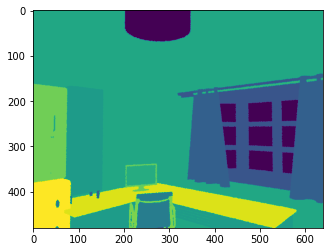

In [175]:
np.unique(matmap)
plt.figure()
plt.imshow(matmap)
plt.show()

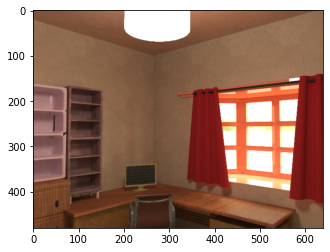

In [181]:
[x for x in np.unique(matG2Ids) if x in np.unique(matmap)]
plt.figure()
plt.imshow(plt.imread('/data/ruizhu/OR-pngs/' + 'mainDiffLight_xml/scene0166_01' + '/im_4.png'))
plt.show()

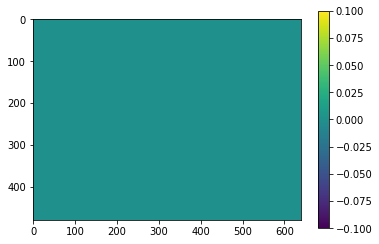

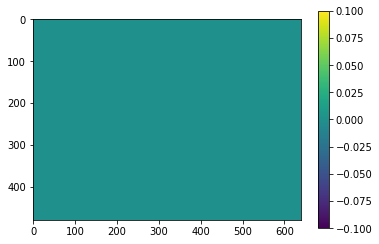

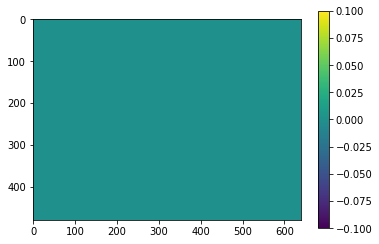

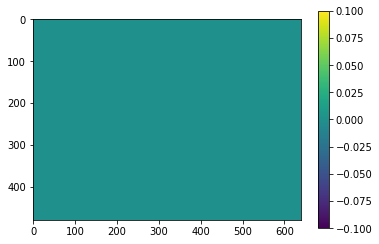

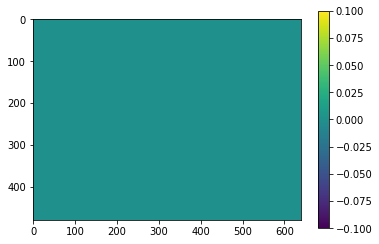

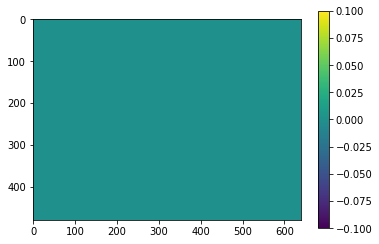

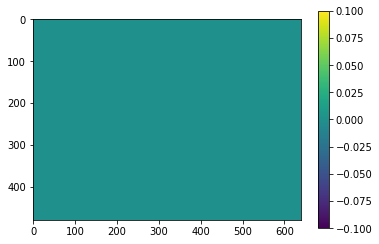

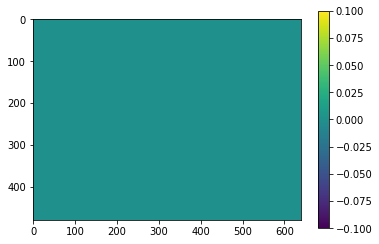

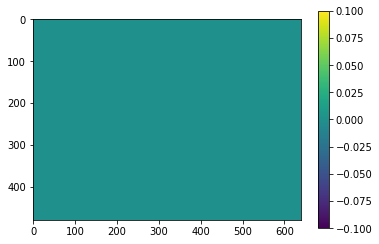

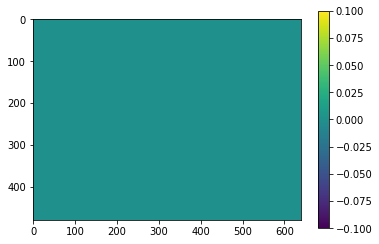

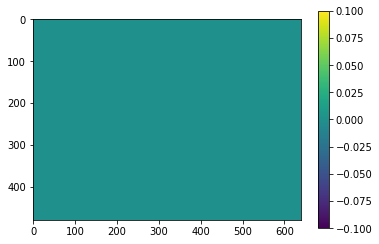

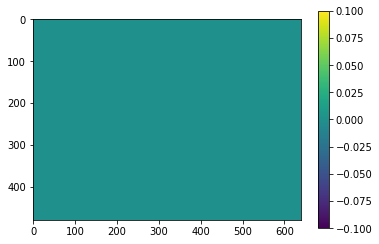

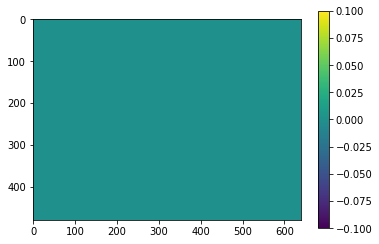

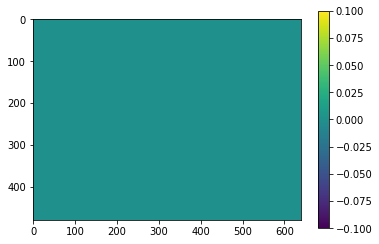

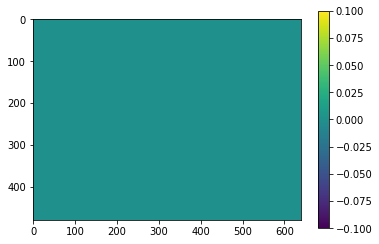

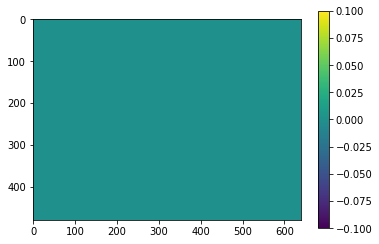

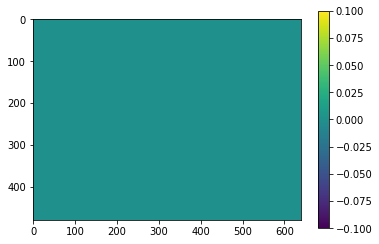

In [190]:
# matG2IdFile = '/data/ruizhu/OR-matpart/mainDiffLight_xml/scene0166_01/immatPartGlobal2Ids_4.npy'
# matG2IdFile = '/data/immatPartGlobal2Ids_4.npy'
matG2IdFile = '/data/immatPartGlobal2Ids_4.npy'
matG2Ids = list(np.load(matG2IdFile) )
# matG2Ids = list(np.load(matG2IdFile.replace('immatPartGlobal2Ids', 'immatPartGlobal1Ids')) )

matG2IdMap = matG2IdFile.replace('immatPartGlobal2Ids_', 'immatPartGlobal2_')

matmap = np.load(matG2IdMap)
for x in matG2Ids:
    matmap0 = matmap==x
    plt.figure()
    plt.imshow(matmap0)
    plt.colorbar()
    plt.show()


In [193]:
np.unique(matmap)

array([    0, 20845, 24909, 29102, 29621, 39453, 40135, 51854, 52405,
       56543, 56544, 58758, 61506, 72225, 74064, 76037, 89806, 94717],
      dtype=int32)

In [192]:
np.unique(matG2Ids)

array([20854, 24939, 29119, 29676, 39480, 40196, 51932, 52475, 56606,
       56607, 58796, 61544, 72272, 74103, 76074, 89877, 94780],
      dtype=int32)

In [195]:
matG1IdFile = '/data/immatPartGlobal1Ids_4.npy'
matG1Ids = list(np.load(matG1IdFile) )
matG1Ids


[186,
 268,
 308,
 316,
 410,
 420,
 516,
 518,
 540,
 540,
 552,
 568,
 714,
 725,
 740,
 850,
 870]

In [199]:
list(set([1, 2, 3]) - set([3, 4, 5]))

[1, 2]

In [208]:
matG2IdFile = '/data/ruizhu/OR-matpart/mainDiffMat_xml1/scene0679_00/immatPartGlobal2Ids_22.npy'
maskG2_path = matG2IdFile.replace('immatPartGlobal2Ids_', 'immatPartGlobal2_')

matG2Ids = sorted(list(np.load(matG2IdFile) )) # [!!!] can be wrong! -> debug
matG2Ids = [x for x in matG2Ids if x != 0]
print(matG2Ids)

matG2IdMap = np.load(maskG2_path)
matG2Ids = sorted(list(np.unique(matG2IdMap)))
matG2Ids = [x for x in matG2Ids if x != 0]
print(matG2Ids)

[11368, 18647, 28782, 28783, 29300, 42271, 48748, 63728, 68202]
[11368, 18647, 28782, 28783, 29300, 42271, 48748, 63728, 68202]
